# Анализ клиентов Телеком оператора 

В данном проекте проводится анализ данных о клиентах телекоммуникационной компании.  
Цель исследования — понять, **какие факторы влияют на отток клиентов (churn)** и как можно сегментировать пользователей для последующих маркетинговых действий.

###  Цели анализа:
1. Определить основные характеристики клиентов, склонных к оттоку.  
2. Сегментировать пользователей по ключевым признакам (возраст, тип контракта, выручка, срок обслуживания и т. д.).  
3. Найти закономерности, позволяющие выстроить стратегию удержания клиентов.  
4. Провести визуализацию распределений признаков и их влияния на отток.

###  Описание данных (`telco_customer_data.csv`):
Каждая строка представляет одного клиента и содержит следующие группы признаков:
- **Демографические:** `Age`, `City`, `Country`  
- **Контрактные:** `Contract`, `Tenure in Months`  
- **Финансовые:** `Total Charges`, `Total Revenue`, `CLTV`  
- **Поведенческие:** `Avg Monthly GB Download`, `Streaming TV`, `Churn Reason`  
- **Целевая переменная:** `Churn` (факт оттока клиента)

---

 **Ожидаемый результат:**  
Выявление профилей клиентов с высоким риском оттока и формирование гипотез для оптимизации тарифов, улучшения сервиса и повышения лояльности.



In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
import plotly.express as px



### Загрузка данных

In [197]:
data = pd.read_csv('data/telco_customer_data.csv')
data

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn,Churn Category,Churn Reason,Churn Score,City,CLTV,Contract,...,Streaming TV,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code
0,72,4,19.44,0,NaN,NaN,51,San Mateo,4849,Two Year,...,0,25,2191.15,0,486.00,0.00,2677.15,0,1,94403
1,27,59,45.62,0,NaN,NaN,27,Sutter Creek,3715,Month-to-Month,...,1,35,3418.20,0,1596.70,0.00,5014.90,1,1,95685
2,59,0,16.07,0,NaN,NaN,59,Santa Cruz,5092,Month-to-Month,...,0,46,851.20,0,739.22,0.00,1590.42,0,0,95064
3,25,27,0.00,0,NaN,NaN,49,Brea,2068,One Year,...,0,27,1246.40,30,0.00,0.00,1276.40,1,0,92823
4,31,21,17.22,1,Dissatisfaction,Network reliability,88,San Jose,4026,One Year,...,0,58,3563.80,0,998.76,0.00,4562.56,0,1,95117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,36,0,7.76,0,NaN,NaN,52,Long Beach,4590,Month-to-Month,...,0,1,19.90,0,7.76,0.00,27.66,0,0,90806
4221,77,22,23.43,0,NaN,NaN,34,San Francisco,5602,One Year,...,0,22,1820.90,0,515.46,29.88,2306.48,0,1,94127
4222,56,0,28.06,0,NaN,NaN,63,Olivehurst,4458,One Year,...,0,18,345.90,0,505.08,0.00,850.98,0,0,95961
4223,45,22,0.00,0,NaN,NaN,38,Westlake Village,4115,Month-to-Month,...,1,57,3437.45,0,0.00,0.00,3437.45,0,1,91361


- В наших данных 4225 строк, что давольно немного
- 52 признака, описывающие разные характеристики клиентов

### Предварительная обработка данных
В начале работы с данными обычно смотрим на пропуски, дубликаты 

In [198]:
# Подсчёт пропусков
missing_counts = data.isnull().sum()

# Берём только признаки, где есть пропуски
missing_counts = missing_counts[missing_counts > 0]

# Формируем датафрейм
missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": 100 * missing_counts / len(data)
}).sort_values("missing_percent", ascending=False)

print(missing_df)


                missing_count  missing_percent
Churn Category           3104        73.467456
Churn Reason             3104        73.467456
Offer                    2324        55.005917
Internet Type             886        20.970414


- Так как признаки `Churn Category`, `Churn Reason`, `Offer` имеют очень много пропусков (более 50% отсутсвующих значений), то они будут удалены.
Так как мы не сможем полноценно восстановить зависимости данных.
- А признак `Internet Type` мы заполним модой.

In [199]:
# Удаляем столбцы с большим количеством пропусков 
columns_to_drop = [
    'Churn Category',
    'Churn Reason',
    'Offer'
]

data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Заполняем пропуски модой
mode_value = data['Internet Type'].mode()[0]
data['Internet Type'] = data['Internet Type'].fillna(value=mode_value)

In [200]:
# Проверим, что пропуски действительно изчезли
data['Internet Type'].isna().sum().item()

0

In [201]:
# Проверка дубликатов
data.duplicated().sum().item()

0

- Дубликатов в данных не наблюдается 

### Разведочный анализ данных
Сейчас мы посмотрим на признаки и зависимости между ними 

#### Типы признаков 
Мы посмотрели на доступные признаки и выделели следующие категории

1.Демография клиента
- Age
- Gender
- Married
- Partner
- Dependents
- Number of Dependents
- Senior Citizen
- Under 30

2.География
- City
- State
- Country
- Zip Code
- Latitude
- Longitude
- Lat Long
- Population

3.Контракт и взаимодействие
- Customer ID
- Customer Status
- Contract
- Quarter
- Tenure in Months
- Number of Referrals
- Referred a Friend

4.Услуги и продукты
- Phone Service
- Multiple Lines
- Internet Service
- Internet Type
- Unlimited Data
- Device Protection Plan
- Online Backup
- Online Security
- Premium Tech Support
- Streaming TV
- Streaming Movies
- Streaming Music
- Paperless Billing

5.Финансы и расходы
- Monthly Charge
- Total Charges
- Total Revenue
- Total Refunds
- CLTV (Customer Lifetime Value)
- Payment Method
- Avg Monthly GB Download
- Avg Monthly Long Distance Charges
- Total Extra Data Charges
- Total Long Distance Charges

6.Лояльность и поведение
- Churn
- Churn Score
- Satisfaction Score

Далее будем выяснять причину оттока

In [248]:
#Среднее значение оттока в зависимости от возраста 
data.groupby('Age')['Churn'].mean()

Age
19    0.128571
20    0.236842
21    0.258427
22    0.208333
23    0.202703
        ...   
76    0.425000
77    0.363636
78    0.459459
79    0.292683
80    0.425000
Name: Churn, Length: 62, dtype: float64

In [205]:
# Показатель оттока в зависимости от города
city_churn_rate = data.groupby('City')['Churn'].sum() / data.groupby('City')['Churn'].count() *100
city_churn_rate.sort_values(ascending= False)

City
Acampo            100.0
La Habra          100.0
Ladera Ranch      100.0
Trabuco Canyon    100.0
Eagleville        100.0
                  ...  
Davis Creek         0.0
Darwin              0.0
Danville            0.0
Nicasio             0.0
Los Banos           0.0
Name: Churn, Length: 1085, dtype: float64

In [206]:
# Количество ушедших клиентов в каждом городе
data.groupby('City')['Churn'].count().sort_values(ascending= False)

City
Los Angeles         175
San Diego           168
San Francisco        61
San Jose             61
Sacramento           60
                   ... 
Mountain Ranch        1
Mount Shasta          1
Brownsville           1
South Lake Tahoe      1
Acampo                1
Name: Churn, Length: 1085, dtype: int64

Если в таблице для какой-то категории (City, State и т.д.) churn rate = 100%, это не всегда реальный вывод.
Часто это результат того, что в категории мало наблюдений (например, 1–2 клиента).

In [208]:
# Влияния реферальной программы на отток клиентов
data.groupby('Churn')['Number of Referrals'].mean()

Churn
0    2.525773
1    0.531668
Name: Number of Referrals, dtype: float64

Обычно клиенты, пришедшие по реферальной программе, более лояльны.

In [210]:
# Влияния премиальной технической поддержки на отток клиентов
premium_tech_support_churn_rate = data.groupby('Premium Tech Support')['Churn'].sum() / data.groupby('Premium Tech Support')['Churn'].count() *100
premium_tech_support_churn_rate.sort_values(ascending= False)

Premium Tech Support
0    31.393001
1    15.003990
Name: Churn, dtype: float64

Рассматриваем связь подключенных услуг (Online Security, Tech Support, Streaming) с оттоком.
Клиенты без базовых защитных/технических сервисов чаще уходят, т.к. ценность тарифа для них ниже.

In [212]:
# Влияние типа контракта на уровень оттока клиентов
contract_churn_rate = data.groupby('Contract')['Churn'].sum() / data.groupby('Contract')['Churn'].count() *100
contract_churn_rate.sort_values(ascending= False)

Contract
Month-to-Month    45.462836
One Year          10.730088
Two Year           2.393617
Name: Churn, dtype: float64

Финансовые факторы оттока

Финансовые показатели (Monthly Charge, Total Revenue, CLTV) часто напрямую влияют на churn.

Высокие счета могут повышать churn, особенно среди новых клиентов.

Высокий CLTV указывает на долгосрочных, стабильных клиентов.


# Анализ всех признаков 


In [214]:
num_cols = data.select_dtypes(include=['int', 'float']).columns.to_list()
cat_col = data.select_dtypes(include=['object'])

In [215]:
# Разделяем признки на числовые, категориальные и бинарные 
num_cols = [
    'Age',
    'Avg Monthly GB Download',
    'Avg Monthly Long Distance Charges',
    'CLTV',
    'Monthly Charge',
    'Number of Dependents',
    'Number of Referrals',
    'Population',
    'Tenure in Months',
    'Total Charges',
    'Total Extra Data Charges',
    'Total Long Distance Charges',
    'Total Refunds',
    'Total Revenue',
]

cat_col = [
    'Zip Code',
    'Satisfaction Score',
    'City',
    'Contract',
    'Internet Type',
    'Lat Long',
    'Payment Method',
]

bin_col = [
    'Streaming Movies',
    'Streaming Music',
    'Streaming TV',
    'Unlimited Data',
    'Senior Citizen',
    'Referred a Friend',
    'Premium Tech Support',
    'Phone Service',
    'Partner',
    'Paperless Billing',
    'Online Security',
    'Online Backup',
    'Multiple Lines',
    'Married',
    'Internet Service',
    'Device Protection Plan',
    'Dependents',
    'Under 30',
    'Gender', 
]

In [217]:
# Анализ числовых признаков, влияющих на отток клиентов
num_results = []
for col in num_cols:
    corr, p_value = pointbiserialr(data[col], data['Churn'])
    num_results.append({'feature': col, 'corr': corr, 'p_value': p_value,})

data_num = pd.DataFrame(num_results).sort_values(by='corr', ascending=False)


In [218]:
# Числовые признаки
data_num

,feature,corr,p_value
4,Monthly Charge,0.180403,3.082054e-32
0,Age,0.102103,2.889233e-11
7,Population,0.063483,3.638576e-05
1,Avg Monthly GB Download,0.057114,2.037104e-04
10,Total Extra Data Charges,0.005764,7.079776e-01
2,Avg Monthly Long Distance Charges,0.005529,7.193775e-01
12,Total Refunds,-0.038499,1.232749e-02
3,CLTV,-0.125495,2.675289e-16
9,Total Charges,-0.209781,3.119335e-43
5,Number of Dependents,-0.222851,1.067309e-48


In [219]:
# Анализ категориальных признаков, влияющих на отток клиентов
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


cat_results = []
for col in cat_col:
    cramers_v_value = cramers_v(data[col], data['Churn'])
    cat_results.append({'feature': col, 'Cramers_V': cramers_v_value})
    
data_cat = pd.DataFrame(cat_results).sort_values(by='Cramers_V', ascending=False)

In [220]:
# Категориальные признаки
data_cat

,feature,Cramers_V
1,Satisfaction Score,0.857780
3,Contract,0.449684
0,Zip Code,0.209659
6,Payment Method,0.200230
5,Lat Long,0.193802
2,City,0.179614
4,Internet Type,0.088542


In [221]:
# # Анализ бинарных признаков, влияющих на отток клиентов
def phi_coefficient(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / n)

bin_results = []
for col in bin_col:
    phi = phi_coefficient(data[col], data['Churn'])
    bin_results.append({'feature': col, 'Phi': phi})
    
data_bin = pd.DataFrame(bin_results).sort_values(by='Phi', ascending=False)

In [222]:
# Бинарные признаки
data_bin

,feature,Phi
16,Dependents,0.249573
14,Internet Service,0.224627
9,Paperless Billing,0.196802
10,Online Security,0.179637
6,Premium Tech Support,0.168960
3,Unlimited Data,0.162456
8,Partner,0.160159
13,Married,0.160159
5,Referred a Friend,0.153847
4,Senior Citizen,0.135610


In [223]:
# Определение наиболее и наименее значимых признаков, влияющих на отток клиентов
def top3_and_bottom3(data, metric):
    top3 = data.nlargest(3, metric)
    bottom3 = data.nsmallest(3, metric)
    return top3, bottom3

num_top3, num_bottom3 = top3_and_bottom3(data_num, 'corr')
cat_top3, cat_bottom3 = top3_and_bottom3(data_cat, 'Cramers_V')
bin_top3, bin_bottom3 = top3_and_bottom3(data_bin, 'Phi')

In [224]:
# Сводная таблица важности признаков
print("=== Numeric Features ===")
display(data_num)
print("\nTop 3:", num_top3['feature'].tolist())
print("Bottom 3:", num_bottom3['feature'].tolist())

print("\n=== Categorical Features ===")
display(data_cat)
print("\nTop 3:", cat_top3['feature'].tolist())
print("Bottom 3:", cat_bottom3['feature'].tolist())

print("\n=== Binary Features ===")
display(data_bin)
print("\nTop 3:", bin_top3['feature'].tolist())
print("Bottom 3:", bin_bottom3['feature'].tolist())

=== Numeric Features ===


,feature,corr,p_value
4,Monthly Charge,0.180403,3.082054e-32
0,Age,0.102103,2.889233e-11
7,Population,0.063483,3.638576e-05
1,Avg Monthly GB Download,0.057114,2.037104e-04
10,Total Extra Data Charges,0.005764,7.079776e-01
2,Avg Monthly Long Distance Charges,0.005529,7.193775e-01
12,Total Refunds,-0.038499,1.232749e-02
3,CLTV,-0.125495,2.675289e-16
9,Total Charges,-0.209781,3.119335e-43
5,Number of Dependents,-0.222851,1.067309e-48



Top 3: ['Monthly Charge', 'Age', 'Population']
Bottom 3: ['Tenure in Months', 'Number of Referrals', 'Total Revenue']

=== Categorical Features ===


,feature,Cramers_V
1,Satisfaction Score,0.857780
3,Contract,0.449684
0,Zip Code,0.209659
6,Payment Method,0.200230
5,Lat Long,0.193802
2,City,0.179614
4,Internet Type,0.088542



Top 3: ['Satisfaction Score', 'Contract', 'Zip Code']
Bottom 3: ['Internet Type', 'City', 'Lat Long']

=== Binary Features ===


,feature,Phi
16,Dependents,0.249573
14,Internet Service,0.224627
9,Paperless Billing,0.196802
10,Online Security,0.179637
6,Premium Tech Support,0.168960
3,Unlimited Data,0.162456
8,Partner,0.160159
13,Married,0.160159
5,Referred a Friend,0.153847
4,Senior Citizen,0.135610



Top 3: ['Dependents', 'Internet Service', 'Paperless Billing']
Bottom 3: ['Phone Service', 'Gender', 'Multiple Lines']


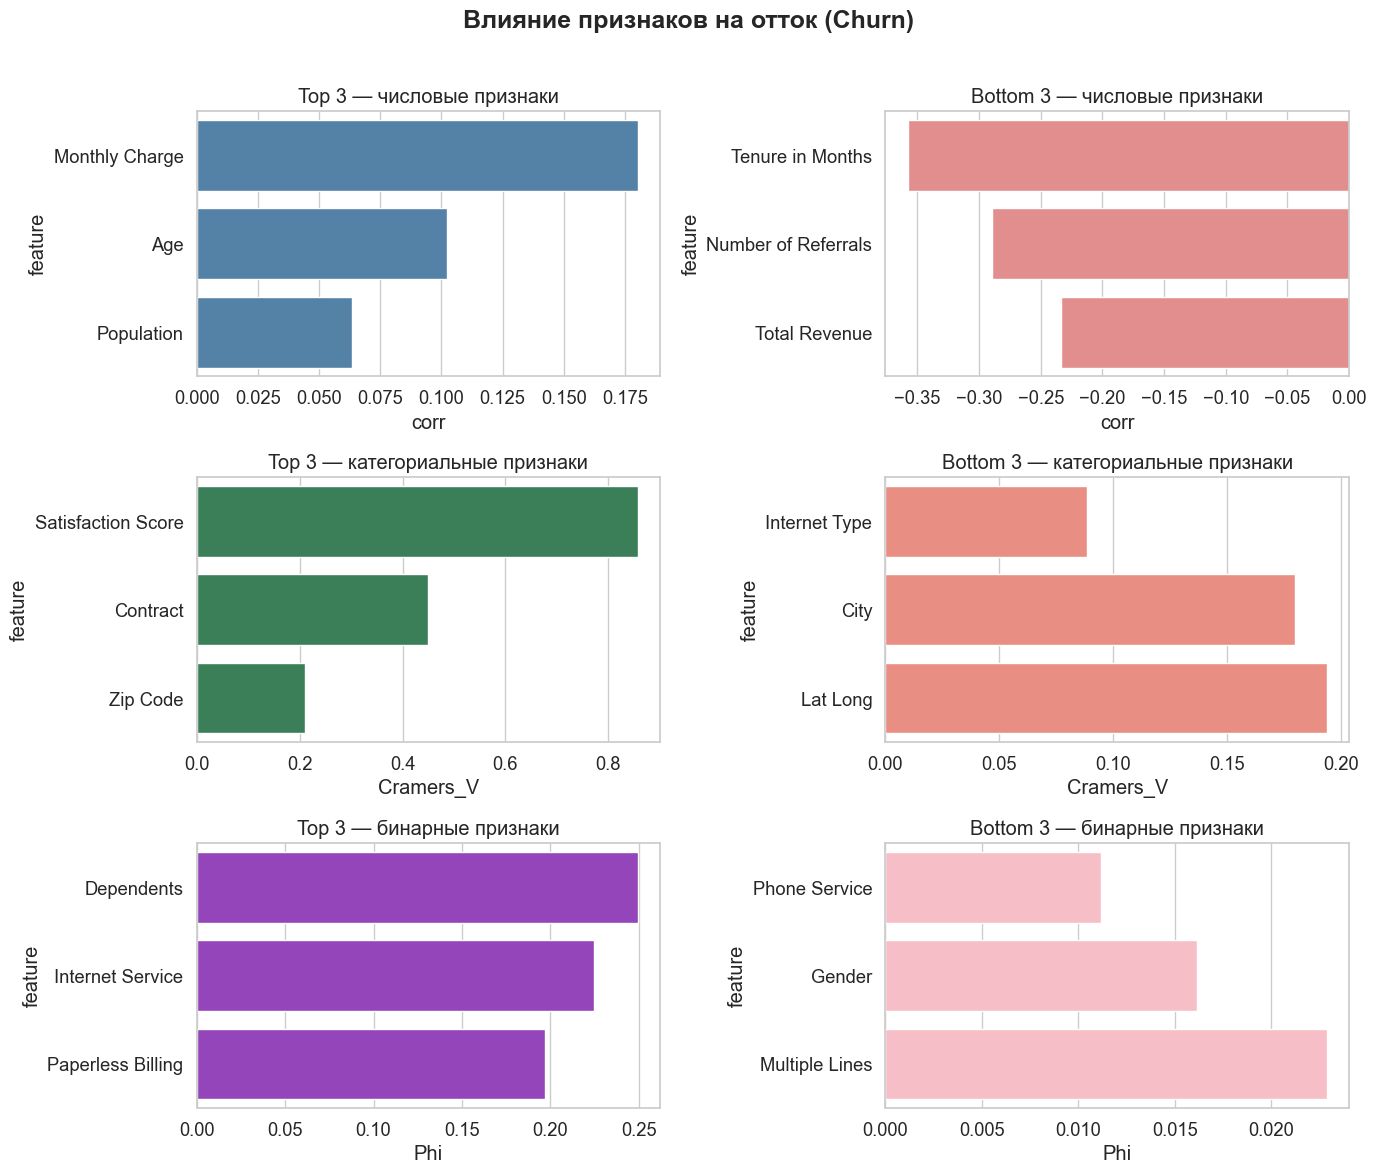

In [225]:
# Визуализация влияния признаков на отток
sns.set(style="whitegrid", font_scale=1.2, palette="muted")

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Влияние признаков на отток (Churn)", fontsize=18, weight='bold')

# --- Числовые ---
sns.barplot(ax=axes[0, 0], data=num_top3, x='corr', y='feature', color='steelblue')
axes[0, 0].set_title("Top 3 — числовые признаки")

sns.barplot(ax=axes[0, 1], data=num_bottom3, x='corr', y='feature', color='lightcoral')
axes[0, 1].set_title("Bottom 3 — числовые признаки")

# --- Категориальные ---
sns.barplot(ax=axes[1, 0], data=cat_top3, x='Cramers_V', y='feature', color='seagreen')
axes[1, 0].set_title("Top 3 — категориальные признаки")

sns.barplot(ax=axes[1, 1], data=cat_bottom3, x='Cramers_V', y='feature', color='salmon')
axes[1, 1].set_title("Bottom 3 — категориальные признаки")

# --- Бинарные ---
sns.barplot(ax=axes[2, 0], data=bin_top3, x='Phi', y='feature', color='darkorchid')
axes[2, 0].set_title("Top 3 — бинарные признаки")

sns.barplot(ax=axes[2, 1], data=bin_bottom3, x='Phi', y='feature', color='lightpink')
axes[2, 1].set_title("Bottom 3 — бинарные признаки")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [226]:
# --- объединяем все результаты корреляций ---
all_corr = pd.concat([
    data_num.assign(Type='Numerical'),
    data_cat.assign(Type='Categorical'),
    data_bin.assign(Type='Binary')
])

# сортировка по абсолютному значению корреляции
all_corr['abs_corr'] = all_corr['corr'].abs()
all_corr_sorted = all_corr.sort_values('abs_corr', ascending=False)

# --- ТОП и НИЗ ---
top_features = all_corr_sorted.head(5)
bottom_features = all_corr_sorted.tail(5)

# отображаем сводную таблицу
display(all_corr_sorted.head(20))



,feature,corr,p_value,Type,Cramers_V,Phi,abs_corr
8,Tenure in Months,-0.358052,5.285184e-128,Numerical,NaN,NaN,0.358052
6,Number of Referrals,-0.289208,3.373180e-82,Numerical,NaN,NaN,0.289208
13,Total Revenue,-0.233286,2.536761e-53,Numerical,NaN,NaN,0.233286
11,Total Long Distance Charges,-0.230346,5.377700e-52,Numerical,NaN,NaN,0.230346
5,Number of Dependents,-0.222851,1.067309e-48,Numerical,NaN,NaN,0.222851
9,Total Charges,-0.209781,3.119335e-43,Numerical,NaN,NaN,0.209781
4,Monthly Charge,0.180403,3.082054e-32,Numerical,NaN,NaN,0.180403
3,CLTV,-0.125495,2.675289e-16,Numerical,NaN,NaN,0.125495
0,Age,0.102103,2.889233e-11,Numerical,NaN,NaN,0.102103
7,Population,0.063483,3.638576e-05,Numerical,NaN,NaN,0.063483


##  Интерпретация влияния признаков на отток клиентов (Churn)

На основании корреляционного анализа были выделены **ТОП-3 и антитоп-3 признака** для каждой категории — числовых, категориальных и бинарных.  
Это позволяет понять, какие факторы сильнее всего влияют на уход клиентов, а какие практически не оказывают влияния.

---

###  Числовые признаки

**Top 3:**
- **Monthly Charge** — самый сильный числовой фактор. Клиенты с высокими ежемесячными расходами чаще уходят, что указывает на чувствительность к цене.  
- **Age** — молодые клиенты чаще прекращают обслуживание, в то время как более взрослые клиенты демонстрируют стабильность.  
- **Population** — слабая положительная связь: в регионах с большей численностью клиентов чаще наблюдается конкуренция и выше риск оттока.

**Bottom 3:**
- **Tenure in Months** — отрицательная корреляция: чем дольше клиент остаётся в компании, тем меньше вероятность оттока.  
- **Number of Referrals** — отрицательная зависимость: клиенты, рекомендующие компанию, лояльнее и реже уходят.  
- **Total Revenue** — сильная отрицательная корреляция: чем больше выручки приносит клиент, тем выше его удержание.

---

###  Категориальные признаки

**Top 3:**
- **Satisfaction Score** — ключевой фактор: высокий уровень удовлетворённости снижает вероятность оттока.  
- **Contract** — клиенты с долгосрочными контрактами значительно реже уходят, чем пользователи помесячных тарифов.  
- **Zip Code** — умеренная зависимость, отражающая возможные региональные различия (например, конкуренция, качество связи).

**Bottom 3:**
- **Internet Type** — слабая корреляция: тип подключения (DSL, Fiber и т.д.) не оказывает существенного влияния.  
- **City** и **Lat Long** — географические признаки не связаны с вероятностью ухода, что подтверждает равномерное распределение поведения клиентов по регионам.

---

###  Бинарные признаки

**Top 3:**
- **Dependents** — наличие иждивенцев снижает вероятность оттока: такие клиенты чаще используют услуги для всей семьи.  
- **Internet Service** — наличие интернет-услуг связано с большей лояльностью (клиенты реже уходят, если пользуются пакетными услугами).  
- **Paperless Billing** — клиенты, использующие электронные счета, демонстрируют более низкий уровень оттока (удобство и автоматизация влияют на удержание).

**Bottom 3:**
- **Phone Service** — наличие телефонной связи слабо влияет на уход, так как это базовая услуга.  
- **Gender** — пол клиента практически не влияет на отток.  
- **Multiple Lines** — количество подключённых линий не является значимым фактором ухода.

---




In [227]:
# Проверка связи между признаками *Customer Status* и *Churn*
tem = data[['Customer Status', 'Churn']]
tem[tem['Customer Status'] == 'Churned']

,Customer Status,Churn
4,Churned,1
5,Churned,1
7,Churned,1
13,Churned,1
15,Churned,1
...,...,...
4190,Churned,1
4193,Churned,1
4195,Churned,1
4205,Churned,1


In [228]:
# Анализ категориальных значений признака *Customer Status*
data['Customer Status'].unique().tolist()

['Stayed', 'Churned', 'Joined']


- Признак Customer Status отражает тот же смысл, что и целевая переменная Churn, различаясь лишь в формулировке категорий.
Корреляция между ними близка к 1, что указывает на дублирование информации.

В рамках предварительного анализа данных было сформулировано простое бизнес-правило для определения оттока клиентов.
Основано оно на предположении, что клиенты, платящие выше среднего по группе ушедших (Churned), более склонны к расторжению договора.

Алгоритм работы:

 - Вычисляется среднее значение месячного платежа (Monthly Charge) среди клиентов, помеченных как Churned;

 - Все клиенты с платежом выше или равным этому порогу классифицируются как потенциально ушедшие (1);

 - Остальные клиенты — как оставшиеся (0).

Такое правило позволяет оперативно сегментировать клиентов по риску оттока, не прибегая к сложным ML-моделям, и может использоваться как базовый ориентир для анализа.

Для более точного прогнозирования оттока в будущем можно применить модель машинного обучения.

В этом случае модель будет учитывать не одно правило, а множество факторов — возраст, стаж клиента, тариф, тип услуг, средние расходы и др.

Однако:

 - Обучение и настройка модели требует времени и вычислительных ресурсов;

 - Итоговая модель менее интерпретируема, чем простое бизнес-правило;

 - Результат может зависеть от качества данных и предварительной обработки.

Поэтому на данном этапе анализа целесообразно использовать бизнес-правило, а ML-подход рассматривать как следующий шаг.



In [229]:
# Применение бизнес-правила для определения оттока клиентов
tem = data[['Monthly Charge', 'Churn']]
tem.groupby('Churn')['Monthly Charge'].mean()

Churn
0    61.662436
1    73.889028
Name: Monthly Charge, dtype: float64

In [230]:
# Функция для применения бизнес-правила
def apply_buisness_rull(data):
    mean_monthly_charge_churn = data[data['Churn'] == 1]['Monthly Charge'].mean()
    data['Churn_Buisness_Rull'] = data['Monthly Charge'].apply(lambda x: 1 if x >=  mean_monthly_charge_churn else 0)

In [231]:
apply_buisness_rull(data)
data['Churn_Buisness_Rull']

0       1
1       1
2       0
3       0
4       0
       ..
4220    0
4221    1
4222    0
4223    0
4224    1
Name: Churn_Buisness_Rull, Length: 4225, dtype: int64

In [234]:
# Считаем количество совпадений
correct_predictions = (data['Churn'] == data['Churn_Buisness_Rull']).sum()

# Общее количество наблюдений
total = len(data)

# Точность в процентах
accuracy_percent = round((correct_predictions / total) * 100, 2)

print(f"Точность нашего бизнес-правила: {accuracy_percent}%")


Точность нашего бизнес-правила: 59.08%


In [250]:
# Оценка точности бизнес-правила прогнозирования оттока
data['Churn'].value_counts(normalize=True)*100

Churn
0    73.467456
1    26.532544
Name: proportion, dtype: float64

Классы несбалансированны, это искажает нашу метрику - точность 

Оценка точности бизнес-правила

Для проверки эффективности бизнес-правила была рассчитана его точность — доля совпадений между фактическими значениями оттока (Churn) и предсказаниями по правилу (Churn_Buisness_Rull).

Результат:

Точность бизнес-правила составила 59.08%.

Это означает, что примерно в 6 из 10 случаев правило корректно определяет, ушёл клиент или остался.
Такой уровень точности приемлем на раннем этапе анализа, когда цель — сформировать простое, объяснимое правило для первичной сегментации клиентов.

In [247]:
# Расчет метрик качества бизнес-правила
TP = ((data['Churn'] == 1) & (data['Churn_Buisness_Rull'] == 1)).sum()
FP = ((data['Churn'] == 0) & (data['Churn_Buisness_Rull'] == 1)).sum()
FN = ((data['Churn'] == 1) & (data['Churn_Buisness_Rull'] == 0)).sum()
TN = ((data['Churn'] == 0) & (data['Churn_Buisness_Rull'] == 0)).sum()

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)


print(f"Precision: {precision:.3f} — доля корректно предсказанных оттоков среди всех предсказанных как ушедшие.")
print(f"Recall: {recall:.3f} — доля реально ушедших клиентов, которых модель правильно определила.")
print(f"Accuracy: {accuracy:.3f} — общая доля правильных предсказаний (и ушедших, и оставшихся).")



Precision: 0.346 — доля корректно предсказанных оттоков среди всех предсказанных как ушедшие.
Recall: 0.609 — доля реально ушедших клиентов, которых модель правильно определила.
Accuracy: 0.591 — общая доля правильных предсказаний (и ушедших, и оставшихся).


<Axes: ylabel='Frequency'>

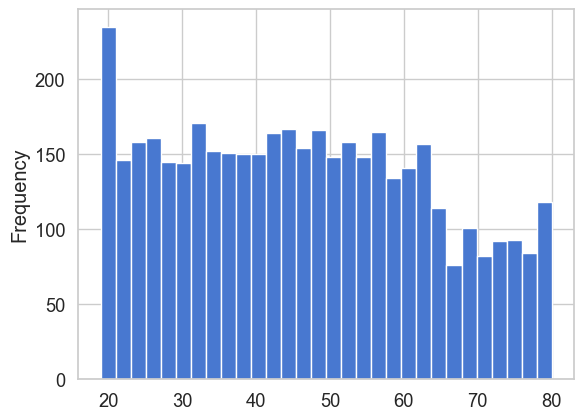

In [238]:
# Анализ распределения возраста клиентов
data['Age'].plot(
    kind='hist',
    bins=30
)

###  Интерпретация гистограммы возраста клиентов

На графике показано распределение возрастов клиентов компании.  

- Большинство клиентов находятся в диапазоне **от 25 до 50 лет** — это основная активная аудитория.  
- После 50 лет наблюдается **снижение количества клиентов**, а после 65 — заметное падение, что может говорить о низкой вовлечённости пожилой аудитории.  
- Есть небольшой пик среди **молодых пользователей (около 20 лет)** — возможно, это новые клиенты, недавно подключившиеся к оператору.  

---

 **Вывод:**  
Возрастная структура пользователей смещена в сторону зрелых клиентов (25–50 лет).  
Это важно учитывать при разработке маркетинговых стратегий:  
- Основной фокус — удержание и повышение лояльности зрелых пользователей.  
- Потенциал роста — молодая аудитория (до 25 лет), которую можно привлекать через digital-каналы и гибкие тарифы.


In [239]:
# Категоризация клиентов по возрасту
def get_age_category(age):
    if age <= 20:
        return '<= 20'
    elif age > 20 and age <= 65:
        return '21-65'
    else:
        return '65+'

In [240]:
# Категоризация клиентов по возрасту
data['Age_category'] = data['Age'].map(get_age_category)

<Axes: xlabel='Age_category'>

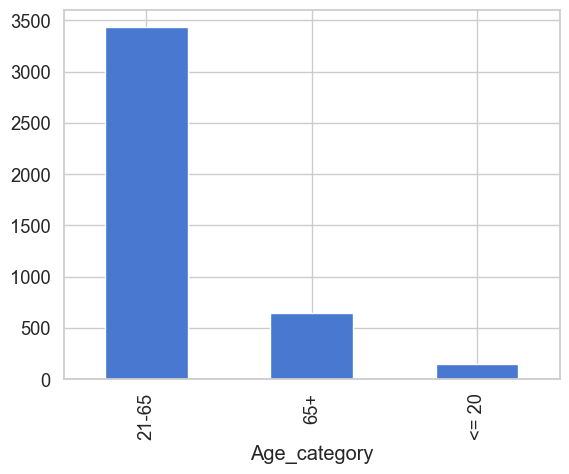

In [241]:
# Визуализация распределения клиентов по возрастным категориям
data['Age_category'].value_counts().plot(
    kind='bar'
)

###  Интерпретация распределения клиентов по возрастным категориям

На графике показано распределение клиентов по возрастным группам.  

- Основная масса клиентов находится в категории **от 21 до 65 лет** — это более **3 000 пользователей**, то есть подавляющее большинство.  
- Группа **старше 65 лет** представлена значительно меньше — около **600 клиентов**, что говорит о сниженной вовлечённости пожилых пользователей.  
- Категория **до 20 лет** — самая малочисленная, менее **200 клиентов**, что указывает на низкую долю молодёжной аудитории.  

---

**Вывод:**  
Основная аудитория компании — **взрослые клиенты среднего возраста (21–65 лет)**, вероятно, экономически активные и наиболее стабильные пользователи.  
Пожилые и молодые клиенты составляют небольшие доли и могут требовать **отдельных маркетинговых подходов**:  
- Для молодых — мобильные тарифы, онлайн-сервисы и гибкие условия.  
- Для пожилых — упрощённые тарифы и повышенное качество обслуживания.


<Axes: ylabel='Density'>

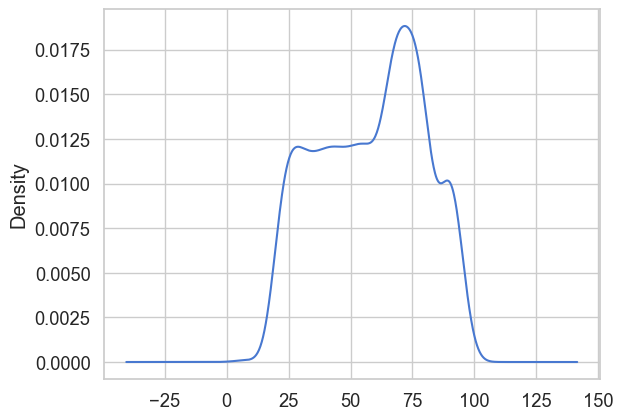

In [242]:
# Анализ распределения показателя *Churn Score*
data['Churn Score'].plot(
    kind='kde',
    #bins=50
)

In [243]:
# Категоризация клиентов по уровню риска оттока (Churn Score)
def get_churn_category(churn_score):
    if churn_score <= 25:
        return 'Низкий'
    elif churn_score > 25 and churn_score <= 55:
        return 'Средний'
    elif churn_score > 55 and churn_score <= 80:
        return 'Высокий'
    else:
        return 'Очень высокий'

In [244]:
# Категоризация клиентов по уровню риска оттока *Churn Score*
data['Churn_Category'] = data['Churn Score'].map(get_churn_category)

<Axes: xlabel='Churn_Category'>

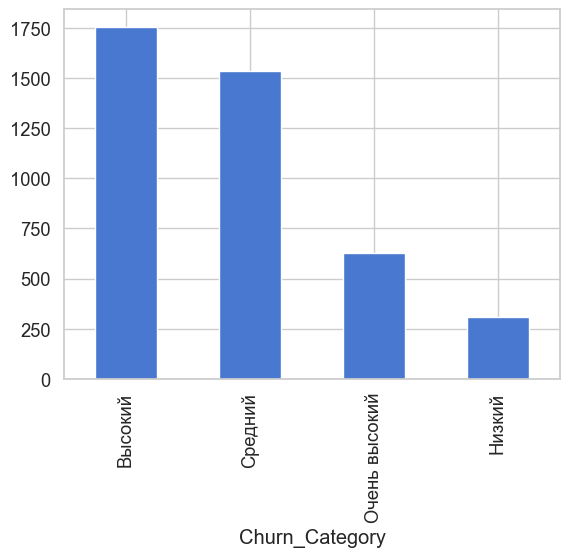

In [245]:
# Распределение клиентов по уровню риска оттока
data['Churn_Category'].value_counts().plot(
    kind='bar'
)

###  Анализ распределения клиентов по категориям оттока (Churn_Category)

На графике показано распределение клиентов по категориям вероятности оттока.  

- **Высокий риск оттока** — самая многочисленная группа (около 1800 клиентов). Это тревожный сигнал: значительная доля пользователей склонна к уходу.  
- **Средний риск оттока** — около 1500 клиентов. Эти пользователи потенциально могут перейти в категорию «высокий риск» без мер по удержанию.  
- **Очень высокий риск оттока** — примерно 700 клиентов. Для них, скорее всего, уже наблюдаются признаки ухода (жалобы, снижение активности и т. д.).  
- **Низкий риск оттока** — наименьшая группа (менее 400 клиентов). Это стабильные пользователи, демонстрирующие высокую лояльность.  

---

 **Вывод:**  
Большинство клиентов компании находятся **в зоне риска (высокий и средний уровни оттока)**.  
Это указывает на необходимость активной работы по удержанию клиентов:  
- Анализ причин ухода (цены, качество связи, поддержка).  
- Разработка программ лояльности для среднего сегмента риска.  
- Укрепление коммуникации с клиентами, попадающими в «высокий риск».




##  Итоговый вывод по анализу клиентов телеком-оператора

В ходе проведённого анализа данных о клиентах телеком-оператора были изучены ключевые факторы, влияющие на **отток (Churn)**, и выявлены закономерности, которые помогут компании повысить удержание клиентов и оптимизировать маркетинговую стратегию.

---

###  Основные результаты анализа

1. **Реферальная программа**
   - Клиенты, пришедшие по реферальной программе, демонстрируют значительно **меньшую склонность к уходу**.
   - Привлечение через рекомендации — эффективный канал для формирования лояльной клиентской базы.

2. **Техническая поддержка и подключённые сервисы**
   - Пользователи без технических и защитных услуг (`Online Security`, `Tech Support`, `Streaming`) **чаще уходят**.
   - Наличие дополнительных услуг повышает удовлетворённость и снижает churn.

3. **Тип контракта**
   - Клиенты с контрактом `Month-to-Month` имеют **высокий уровень оттока (≈45%)**.
   - Долгосрочные контракты (`One Year`, `Two Year`) связаны с **низким churn (до 3%)**, что говорит о стабильности и доверии.

4. **Финансовые показатели**
   - Более высокие ежемесячные платежи (`Monthly Charge`) увеличивают вероятность оттока.
   - Высокий CLTV и длительная история обслуживания коррелируют с низким риском ухода.

5. **Возрастная структура**
   - Основная аудитория — **клиенты 21–65 лет**, что соответствует активной экономической группе.
   - Молодые (<20) и пожилые (>65) пользователи составляют малую часть базы.
   - Для них возможны специализированные маркетинговые предложения:
     - Молодёжь — гибкие digital-тарифы;
     - Пожилые — упрощённые тарифы и приоритетная поддержка.

6. **Индикатор риска оттока (Churn Score)**
   - Большинство клиентов имеют **низкий и средний уровень риска**.
   - Однако около трети клиентов находятся в **зонах высокого и очень высокого риска** — это целевая группа для удержания.

---

###  Проверка бизнес-правила
На основе среднего месячного платежа (`Monthly Charge`) среди ушедших клиентов было построено простое **бизнес-правило для предсказания оттока**.

- Точность правила составила **≈59%**, что является **приемлемым результатом для первичной сегментации**.
- Модель показала:
  - **Precision:** 0.35 — точность определения уходящих клиентов;
  - **Recall:** 0.61 — доля реально ушедших клиентов, верно предсказанных моделью;
  - **Accuracy:** 0.59 — общая доля правильных предсказаний.

---

###  Рекомендации для бизнеса

1.  **Укреплять программы лояльности** — реферальные, скидочные и накопительные предложения.  
2.  **Продвигать защитные и технические сервисы** как часть комплексных тарифов.  
3.  **Стимулировать переход на долгосрочные контракты**, предлагая бонусы и фиксированные цены.  
4.  **Оптимизировать тарифную сетку** для клиентов с высокими ежемесячными расходами.  
5.  **Разработать персонализированные кампании удержания** для клиентов с высоким и очень высоким риском оттока.

---

###  Заключение

Проведённый анализ позволил:
- выявить основные факторы, влияющие на churn;  
- определить портрет лояльного клиента;  
- построить простое, интерпретируемое бизнес-правило для первичной оценки риска оттока.

Таким образом, данная работа формирует **основу для последующего внедрения ML-моделей прогнозирования churn**, которые смогут значительно повысить точность и автоматизировать процесс удержания клиентов.
